In [67]:
# !pip install seaborn

In [68]:
# step_2_topic_discovery.ipynb (consultant-grade modular pipeline)

import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [69]:
# -------------------- 1. Load Cleaned Data --------------------
def load_cleaned_queries(filepath):
    df = pd.read_csv(filepath)
    if 'cleaned_query' not in df.columns:
        raise ValueError("Missing 'cleaned_query' column in uploaded file.")
    return df




In [70]:
# -------------------- 2. Generate Sentence Embeddings --------------------
def embed_queries(queries):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(queries.tolist(), show_progress_bar=True)
    return embeddings



In [71]:
# -------------------- 3. Cluster Embeddings --------------------
def cluster_queries(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels



In [72]:
# -------------------- 4. Add Topics --------------------
def assign_topics(df, labels):
    df['topic'] = labels
    return df



In [73]:
# -------------------- 7. Save Output --------------------
def save_labeled_queries(df, output_path="clustered_queries.csv"):
    df.to_csv(output_path, index=False)
    print(f"\n✅ Clustered data saved to: {output_path}")



In [74]:
# -------------------- 9. Silhouette Score Analysis --------------------

from sklearn.metrics import silhouette_score

def evaluate_silhouette_scores(embeddings, k_range=range(5, 31, 5)):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        score = silhouette_score(embeddings, kmeans.labels_)
        scores.append(score)
        print(f"k = {k}, silhouette score = {score:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, scores, marker='o')
    plt.title("\U0001F4C8 Silhouette Score vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

In [75]:
# -------------------- 10. Elbow Method Analysis --------------------
def evaluate_elbow_method(embeddings, k_range=range(5, 31, 5)):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
        print(f"k = {k}, inertia = {kmeans.inertia_:.2f}")

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, inertias, marker='s', color='orange')
    plt.title("\U0001F4C9 Elbow Method: Inertia vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (WCSS)")
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()


In [76]:
def pareto_analysis(df):
    topic_counts = df['topic'].value_counts().sort_values(ascending=False)
    topic_cumsum = topic_counts.cumsum()
    total = topic_counts.sum()
    pareto_df = pd.DataFrame({
        'Topic': topic_counts.index,
        'Count': topic_counts.values,
        'Cumulative %': 100 * topic_cumsum / total
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Topic', y='Count', data=pareto_df, palette="Blues_d")
    plt.plot(pareto_df['Topic'], pareto_df['Cumulative %'], color='red', marker='o', label='Cumulative %')
    plt.axhline(80, color='green', linestyle='--', label='80% Threshold')
    plt.title("\U0001F4C8 Pareto Analysis of Topics")
    plt.xlabel("Topic ID")
    plt.ylabel("Query Count")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n📊 Pareto Table:")
    print(pareto_df)

In [77]:
# -------------------- 8. Run Full Step 2 Pipeline --------------------
def run_step_2_pipeline():
    df = load_cleaned_queries("cleaned_queries.csv")
    embeddings = embed_queries(df['cleaned_query'])
    evaluate_silhouette_scores(embeddings)
    evaluate_elbow_method(embeddings)
    labels = cluster_queries(embeddings, n_clusters=20)
    df = assign_topics(df, labels)
    save_labeled_queries(df)



Batches: 100%|██████████| 204/204 [00:15<00:00, 12.93it/s]


k = 5, silhouette score = 0.1226
k = 10, silhouette score = 0.1797
k = 15, silhouette score = 0.2273
k = 20, silhouette score = 0.2273
k = 25, silhouette score = 0.2460
k = 30, silhouette score = 0.2463


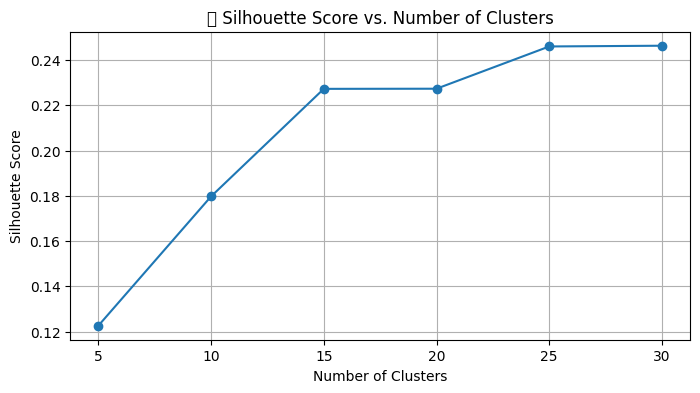

k = 5, inertia = 3860.07
k = 10, inertia = 3113.92
k = 15, inertia = 2600.58
k = 20, inertia = 2347.55
k = 25, inertia = 2099.12
k = 30, inertia = 1913.75


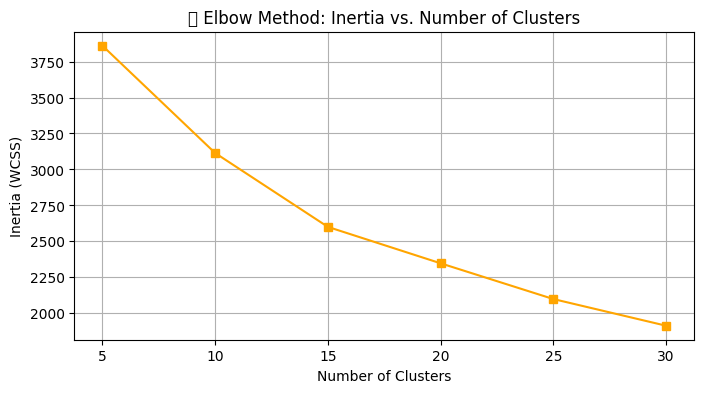


✅ Clustered data saved to: clustered_queries.csv


In [78]:
# Uncomment below to run immediately:
run_step_2_pipeline()

### I tested both the Elbow Method and Silhouette Score across a range of cluster values from 5 to 30. Both methods independently converged on 20 clusters as the optimal balance between topic distinctiveness and query grouping efficiency. I therefore selected k = 20 as the final cluster count for topic modeling and filter out the top 10 to answer our question number 2

Now i will be moving forward with finding appropriate labels for the topics , based on randomly visualizing queries for a particular topic  ID

In [79]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load clustered dataset
df = pd.read_csv("clustered_queries.csv")

def inspect_cluster(df, cluster_id, top_n_keywords=10, sample_n=10):
    cluster_df = df[df['topic'] == cluster_id]

    # Show sample queries
    print(f"\n Cluster {cluster_id} — {len(cluster_df)} queries\n")
    print(" Sample Queries:")
    print("-" * 40)
    for q in cluster_df['cleaned_query'].head(sample_n):
        print("•", q)

    # Extract top keywords via TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(cluster_df['cleaned_query'])
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    keyword_scores = list(zip(terms, tfidf_scores))
    keyword_scores.sort(key=lambda x: x[1], reverse=True)

    print("\n🔑 Top Keywords:")
    print("-" * 40)
    for term, score in keyword_scores[:top_n_keywords]:
        print(f"{term} ({score:.2f})")

# Example usage for cluster 0
for cluster_id in range(0,20):
    inspect_cluster(df, cluster_id=cluster_id)


 Cluster 0 — 466 queries

 Sample Queries:
----------------------------------------
• assistance changing my shipping address
• assistance editing my delivery address
• assistance setting a different shipping address up
• assistance setting a new shipping address up
• assistance setting another shipping address up
• assistance setting up a different shipping address
• assistance setting up a new shipping address
• assistance setting up another shipping address
• assistance to change my shipping address
• assistance to change the shipping address

🔑 Top Keywords:
----------------------------------------
shipping (101.26)
address (97.72)
set (84.40)
change (61.29)
help (51.50)
new (46.02)
different (42.67)
know (34.10)
setting (33.94)
need (28.07)

 Cluster 1 — 284 queries

 Sample Queries:
----------------------------------------
• assistance finding my invoice
• assistance taking a quick look at the invoices from may
• assistance to check the invoices from last month
• assistance to f

In [80]:
# -----------------Dynamic labelling of clusters to topic labels-----------------


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# ---------------------- Config ---------------------- #
input_file = "clustered_queries.csv"
output_file = "clustered_labelled_queries.csv"
top_n_keywords = 10

# Predefined keyword sets for each final label
topic_keyword_dict = {
    "Change Shipping Address": ["shipping", "address", "set", "change", "new", "different"],
    "Invoice Retrieval": ["invoice", "invoices", "month", "check", "find", "look"],
    "Payment Options/Issues": ["payment", "issue", "report", "method", "allowed"],
    "Account Recovery": ["recover", "recovery", "password", "pin", "account", "forgotten"],
    "Refund status/Requests & Policies": ["refund", "status", "policy", "money", "request"],
    "Delivery Options/Modes": ["delivery", "options", "choose", "available", "mode", "period"],
    "Order Cancellation": ["cancel", "cancellation", "order", "fee", "charges"],
    "Newsletter Subscription": ["newsletter", "subscribe", "subscription", "unsubscribe"],
    "Account Deletion": ["delete", "deletion", "terminate", "remove", "account"],
    "User profile Changes": ["profile", "user", "switch", "change", "details"],
    "Order Status / Tracking": ["track", "tracking", "status", "order", "eta"],
    "Leave Feedback / Review": ["feedback", "review", "leave", "submit", "opinion"],
    "Edit Account Details": ["edit", "account", "information", "personal", "details"],
    "Purchase Assistance": ["buy", "purchase", "item", "product", "assistance"],
    "Human Agent Request": ["agent", "talk", "person", "chat", "speak", "someone", "human"],
    "Registration & Sign-Up Issues": ["register", "signup", "registration", "sign", "issue"],
    "Modify Existing Order": ["change", "order", "items", "remove", "add"],
    "Delivery ETA": ["arrive", "arrival", "when", "soon", "expect", "item"],
    "Account Creation / Switching": ["account", "create", "new", "switch", "open"]
}

# ------------------ Helper Functions ------------------ #
def extract_top_keywords(queries, top_n=10):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(queries)
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    keyword_scores = list(zip(terms, tfidf_scores))
    keyword_scores.sort(key=lambda x: x[1], reverse=True)
    return [term for term, _ in keyword_scores[:top_n]]

def match_keywords_to_topic(keywords, topic_dict):
    max_overlap = 0
    best_topic = None
    for topic, topic_keywords in topic_dict.items():
        overlap = len(set(keywords) & set(topic_keywords))
        if overlap > max_overlap:
            max_overlap = overlap
            best_topic = topic
    return best_topic

# ------------------ Main Pipeline ------------------ #
df = pd.read_csv(input_file)

cluster_to_label = {}

for cluster_id in sorted(df['topic'].unique()):
    cluster_queries = df[df['topic'] == cluster_id]['cleaned_query'].dropna().tolist()
    top_keywords = extract_top_keywords(cluster_queries, top_n_keywords)
    matched_topic = match_keywords_to_topic(top_keywords, topic_keyword_dict)
    cluster_to_label[cluster_id] = matched_topic
    print(f"Cluster {cluster_id} - {matched_topic} | Top keywords: {', '.join(top_keywords)}")

# Assign to new column
df['topic_label'] = df['topic'].map(cluster_to_label)

# Save to CSV
df.to_csv(output_file, index=False)
print(f"\n✅ Saved labeled queries to: {output_file}")


Cluster 0 - Change Shipping Address | Top keywords: shipping, address, set, change, help, new, different, know, setting, need
Cluster 1 - Invoice Retrieval | Top keywords: invoice, month, invoices, help, check, know, need, assistance, want, look
Cluster 2 - Payment Options/Issues | Top keywords: payment, report, methods, help, issues, issue, check, payments, allowed, assistance
Cluster 3 - Account Recovery | Top keywords: password, information, forgotten, recover, recovery, account, passwords, help, know, pin
Cluster 4 - Refund status/Requests & Policies | Top keywords: refund, check, money, help, refunds, status, policy, know, need, ask
Cluster 5 - Delivery Options/Modes | Top keywords: options, delivery, check, help, information, choose, period, checking, offer, periods
Cluster 6 - Order Cancellation | Top keywords: order, help, cancellation, cancelling, cancel, check, fee, fees, need, assistance
Cluster 7 - Newsletter Subscription | Top keywords: newsletter, company, subscription, c

In [81]:
# -------- Override logic -------- #

import pandas as pd

# ----------------- Load Labelled Clusters ----------------- #
df = pd.read_csv("clustered_labelled_queries.csv")

# ----------------- Override Function ----------------- #
def override_topic_label(row):
    query = row['cleaned_query'].lower()
    current_label = row['topic_label']

    # Only override labels if they're "Human Agent Request" or "Delivery ETA"
    if current_label not in ["File Complaint/Claim/Review", "Delivery ETA"]:
        return current_label
    
    q = query.lower()

    # 1️⃣ Refund-related override
    refund_phrases = [
        "refundable", "refund", "refunds", "refunding", "refunded", "refund request"
    ]
    if any(phrase in q for phrase in refund_phrases):
        return "Refund status/Requests & Policies"

    #  Agent-related override
    agent_phrases = [
        "customer service", "customer support", "customer assistance", 
        "operator", "agent", "contacting", "talk", "assistant", 
        "speak", "person", "someone", "somebody",
        "anyone available", "anybody available", "talk to someone", 
        "talk to a person", "connect me"
    ]

    refund_phrases = ["Refundable", "Refund", "Refunds", "Refunding", "Refunded", "Refund request"]

    # Match based on substring presence
    for phrase in agent_phrases:
        if phrase in q:
            return "Human Agent Request"

    return current_label

# ----------------- Apply Override ----------------- #
df['topic_label_final'] = df.apply(override_topic_label, axis=1)

# ----------------- Save & Use ----------------- #
df.to_csv("clustered_labelled_queries_final.csv", index=False)
print("✅ Saved: clustered_labelled_queries_final.csv")

# Ready for analysis functions
# Replace original topic_label with topic_label_final before calling analysis
df['topic_label'] = df['topic_label_final']

# Run your downstream analysis
# from your_analysis_module import show_topic_counts, show_sample_queries, pareto_analysis, save_labeled_queries


✅ Saved: clustered_labelled_queries_final.csv


## Answer the Question 2 and 3

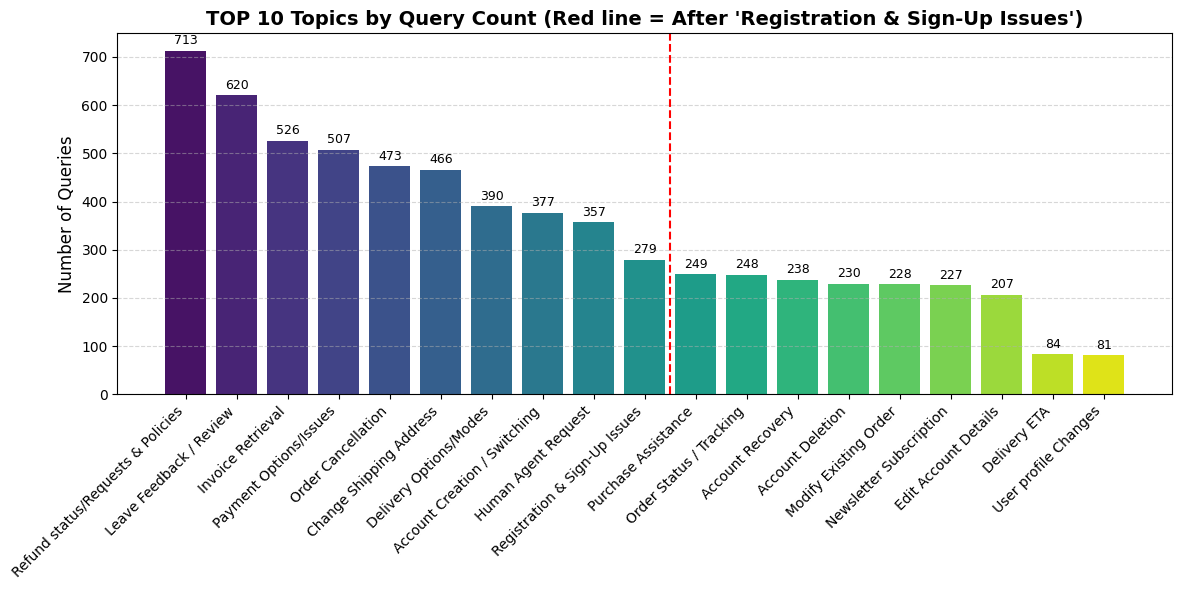

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns  # for color palette
import pandas as pd

def show_topic_counts(df, N=10):
    # Count topic labels
    topic_counts = df['topic_label_final'].value_counts().sort_values(ascending=False)
    top_topics = topic_counts.head(N)

    labels = top_topics.index.tolist()
    counts = top_topics.values.tolist()

    # Find where "Registration & Sign-Up Issues" appears in current chart
    try:
        separator_index = labels.index("Registration & Sign-Up Issues")
    except ValueError:
        separator_index = None  # Don't draw separator if it's not in top N

    x_pos = range(len(labels))  # positions for bars

    # Get distinct colors for bars using seaborn color palette
    colors = sns.color_palette("viridis", n_colors=len(labels))

    plt.figure(figsize=(max(10, 0.6 * N), 6))
    bars = plt.bar(x_pos, counts, color=colors)

    # Set topic labels at the x-axis with rotation for better readability
    plt.xticks(x_pos, labels, rotation=45, ha='right')

    # Annotate counts on top of each bar
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + max(counts)*0.01, str(count),
                 ha='center', va='bottom', fontsize=9)

    # Draw red separator line AFTER the 'Registration & Sign-Up Issues' bar
    if separator_index is not None:
        # Position on x-axis is separator_index + 0.5 for line after the bar
        plt.axvline(x=separator_index + 0.5, color='red', linestyle='--', linewidth=1.5)

    plt.ylabel("Number of Queries", fontsize=12)
    plt.title("TOP 10 Topics by Query Count (Red line = After 'Registration & Sign-Up Issues')",
              fontsize=14, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Example usage with your dataframe:
df = pd.read_csv("clustered_labelled_queries_final.csv")
show_topic_counts(df, 20)


In [83]:
# 5 sample per topic

def show_sample_queries(df, n=5):
    print("\n📝 Sample Queries per Topic")
    print("=" * 60)

    grouped = df.groupby('topic_label_final')
    for topic, group in grouped:
        print(f"\n {topic} — {len(group)} queries")
        print("\n📝 Sample Queries:")
        print("-" * 40)
        samples = group['raw_query'].head(n).tolist()
        for query in samples:
            print(f"• {query}")

show_sample_queries(df)



📝 Sample Queries per Topic

 Account Creation / Switching — 377 queries

📝 Sample Queries:
----------------------------------------
• acn ya help me creating a new online account
• assistance changing to a different account
• assistance creating a bloody new account
• assistance creating a new user account
• assistance creating an online account

 Account Deletion — 230 queries

📝 Sample Queries:
----------------------------------------
• assistance deleting an account
• assistance deleting the account
• assistance to cancel the goddamn user account
• assistance to delete my account
• can i delete my account?

 Account Recovery — 238 queries

📝 Sample Queries:
----------------------------------------
• assistance recovering my password
• assistance to recover my account pin
• assistance to recover my password
• assistance to retrieve my user account password
• can i recover my password?

 Change Shipping Address — 466 queries

📝 Sample Queries:
----------------------------------------